## For Colabs

In [42]:
from getpass import getpass
import os

user = "OliverJBoom"
password = getpass('github password')

os.environ['GITHUB_AUTH'] = user + ':' + password
os.chdir("/content")
!rm -rf "/content/acse-9-independent-research-project-OliverJBoom"
!git clone https://$GITHUB_AUTH@github.com/msc-acse/acse-9-independent-research-project-OliverJBoom.git
os.chdir("acse-9-independent-research-project-OliverJBoom/Src")

github password··········
Cloning into 'acse-9-independent-research-project-OliverJBoom'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 543 (delta 62), reused 51 (delta 22), pack-reused 446
Receiving objects: 100% (543/543), 9.03 MiB | 24.93 MiB/s, done.
Resolving deltas: 100% (300/300), done.


In [2]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)
path = "/content/gdrive/My Drive/Chai/Data"

Mounted at /content/gdrive/


## Loading Packages

In [ ]:
from deeplearning import *
from models import *
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import pickle
from preprocessing import *
from statistics import median
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from eval_inspect import *
import warnings

warnings.filterwarnings("ignore")

set_seed(42)

### Insuring that training is done on GPU if available

In [2]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

No GPU available!


## Loading Data

In [36]:
path = "Data/Commodity_Data/"
universe_dict = universe_select(path, "MTL")
use_lg_returns = False
auto_regressive = False
use_PCA = True

if auto_regressive: assert (auto_regressive!=use_PCA)

## Preprocessing

In [37]:
# Renaming the columns to price
universe_dict = price_rename(universe_dict)

# Cleaning the dataset of any erroneous datapoints
universe_dict = clean_dict_gen(universe_dict)

# Making sure that all the points in the window have consistent length
universe_dict = truncate_window_length(universe_dict)

# # Generating the dataset
if use_lg_returns:
    # Lg Returns Only
    df_full = generate_dataset(universe_dict, lg_only=True, price_only=False)
    target_col = ["cu_lme", "al_lme", "sn_lme", "pb_lme", "ni_lme"]
    
else:
    # Price Only
    df_full = generate_dataset(universe_dict, lg_only=False, price_only=True)
    target_col = ["price_cu_lme", "price_al_lme", "price_sn_lme", "price_pb_lme", "price_ni_lme"]

if auto_regressive:
    df_full = df_full[target_col]

Included Instrument:
al_shfe
al_lme
al_comex_p
Rows removed: 1
al_comex_s
al_lme_s
yuan
cu_shfe
cu_lme
cu_comex_p
cu_comex_s
peso
sol
bdi
ted
vix
skew
gsci
sn_lme
pb_lme
ni_lme


### Visualising the dataset

In [38]:
df_full.head(5)
# df_full.tail(5)

# Visualise the plots if desired
# visualise_df(df_full)

,price_al_shfe,price_al_lme,price_al_comex_p,price_al_comex_s,price_al_lme_s,price_yuan,price_cu_shfe,price_cu_lme,price_cu_comex_p,price_cu_comex_s,price_peso,price_sol,price_bdi,price_ted,price_vix,price_skew,price_gsci,price_sn_lme,price_pb_lme,price_ni_lme
date,,,,,,,,,,,,,,,,,,,,
2014-06-04,13270.0,1812.75,2189.75,13403.0,5170375.0,6.2494,49570.0,6834.0,3.0935,16395.0,552.09,2.789,959.0,0.0355,12.08,121.48,645.9893,23225.0,2103.0,19025.0
2014-06-05,13235.0,1824.25,2201.00,13852.0,5160575.0,6.2548,49520.0,6803.0,3.0910,16440.0,550.66,2.789,977.0,0.0355,11.68,122.21,646.6336,23245.0,2109.0,19030.0
2014-06-06,13280.0,1856.75,2222.25,14276.0,5152975.0,6.2498,49550.0,6696.0,3.0530,16323.0,549.03,2.789,989.0,0.0330,10.73,122.88,646.6281,23195.0,2109.0,18875.0
2014-06-09,13385.0,1886.00,2257.00,14876.0,5146525.0,6.2397,48720.0,6688.5,3.0455,16183.0,549.65,2.783,999.0,0.0355,11.15,124.67,651.2814,23295.0,2141.0,18905.0
2014-06-10,13455.0,1865.50,2250.75,15138.0,5140000.0,6.2240,48420.0,6710.0,3.0550,16320.0,553.49,2.789,1004.0,0.0406,10.99,125.38,648.0516,22865.0,2140.0,18775.0


### Normalizing the dataset

In [43]:
# Forecast length
forecast_length = 5
# forecast_length = 22
# forecast_length = 66
# forecast_length = 132

# Data scaling
scaler_data_X = MinMaxScaler()
scaler_data_y = MinMaxScaler()

df_target = df_full[target_col]

data_X = scaler_data_X.fit_transform(df_full)[:-forecast_length, :]
# Need to have an independent scaler for inverse_transforming later
data_y = scaler_data_y.fit_transform(df_target)

# Offset target one forecast length
data_y = data_y[forecast_length:, :]

### PCA

In [44]:
# Reducing the dataset to containing a threshold amount of variance
if use_PCA:
    n_dim = dimension_selector(data_X, thresh=0.95)
    data_X = dimension_reduce(data_X, n_dim)

Number of dimensions: 7
Explained Variance Sum: 0.952
Explained Variance Composition [0.4731094  0.28411277 0.08974061 0.04456996 0.02808504 0.01800107
 0.01438797]


### Slicing Series into Windows

In [45]:
# The input size of each time series window
series_length = 132
  
data_X, data_y = slice_series(data_X, data_y, series_length, dataset_pct=1.0)

# [Number of series, time series length, number of features]
print("Data X shape", data_X.shape,
      "\nData y shape", data_y.shape)

Data X shape (1178, 132, 7) 
Data y shape (1178, 5)


### Hyperparameters

In [47]:
# Hyperparameters
learning_rate = 1e-2
momentum = 0.5
weight_decay = 0

# Batch Parameters
batch_size = 32

# Training Parameters
n_epochs = 2
patience = 60
disp_freq= 10
fig_disp_freq= 10

# Model Parameters
num_features = data_X.shape[2]
hidden_dim = 8
dense_hidden = 32
num_layers = 1
output_dim = data_y.shape[1]
dropout = 0

### Initialising the model

In [48]:
model = LSTM(num_features=num_features, 
             hidden_dim=hidden_dim,
             dense_hidden=dense_hidden,
             series_length = series_length,
             batch_size=batch_size,
             output_dim=output_dim, 
             num_layers=num_layers, 
             device=device,
             dropout=dropout)

model.to(device)

print("num_features %i \nhidden_dim %i\nseries_length %i \nbatch_size %i\noutput_dim %i \nnum_layers %i"
      % (num_features, hidden_dim, series_length, batch_size,output_dim, num_layers))

print('data_X ', data_X.shape, '\ndata_y', data_y.shape)

num_features 7 
hidden_dim 8
series_length 132 
batch_size 32
output_dim 5 
num_layers 1
data_X  (1178, 132, 7) 
data_y (1178, 5)


In [49]:
# Loading trained model
# model = torch.load("/content/gdrive/My Drive/Chai/Models/Pths/" + "partial_dataset_LSTM_0_1206.pth")
# model.to(device)

Epoch: 0 Train: 10.83276 Val: 14.89628  Time: 1.683  Best Val: 14.89628


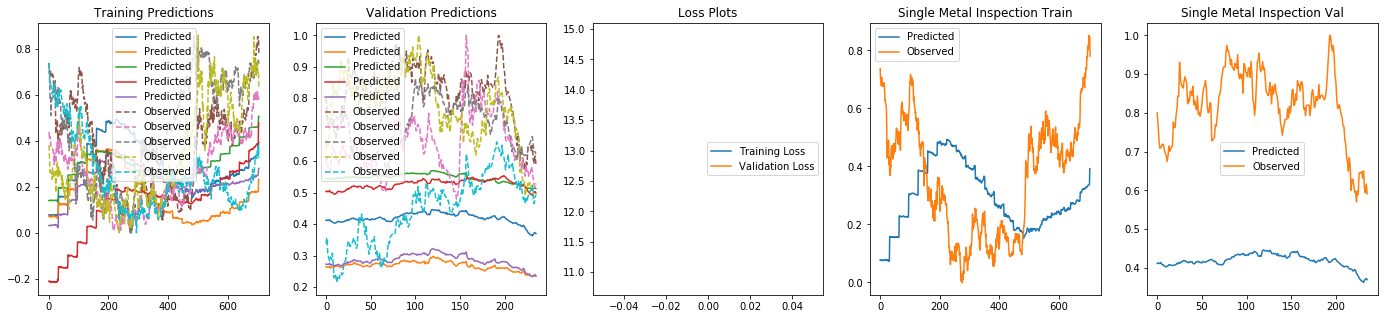

In [50]:
optimiser = torch.optim.Adam(model.parameters(), learning_rate)

"""Do I need to declare a data explicitly in the dataset"""
learning = DeepLearning(model=model, 
                        data_X=data_X, 
                        data_y=data_y, 
                        n_epochs=n_epochs,
                        optimiser=optimiser,
                        batch_size=batch_size,
                        debug=False, 
                        disp_freq=disp_freq,
                        fig_disp_freq=fig_disp_freq, 
                        device=device,
                        patience=patience, 
                        scaler_data_X=scaler_data_X,
                        scaler_data_y=scaler_data_y)


# Splitting the data into the train, validation and test sets
learning.train_val_test()
learning.training_wrapper()

### Evaluating on Test Data

In [51]:
# learning.val_loader = learning.test_loader
learning.evaluate(learning.best_model, learning.test_loader)

5.921403456542452

### Saving Model Object

In [150]:
model_name = "MTL_Auto" + "_F" + str(forecast_length)
print(model_name)

# Saving Pickle
pickle.dump(learning, open("Results/Pickles/" + model_name, 'wb'))
# Saving Pth
model_save(model, model_name)

MTL_Auto_F132
Saving model: Models/MTL_Auto_F132.pth


### Loading Example

In [151]:
# Load Pickle
learning = pickle.load(open("Results/Pickles/" + "Learning_Univariate_SS_H4_5_", 'rb'))

# Loading Learning Object
model = model_load(path="Results/Pths/", model_name="Univariate_SS_H4_5_")

### Rescaling & Plotting

In [52]:
# Observed
train_true = learning.scaler_data_y.inverse_transform(learning.y_train.numpy())
val_true  = learning.scaler_data_y.inverse_transform(learning.y_val.numpy())
test_true  = learning.scaler_data_y.inverse_transform(learning.y_test.numpy())

# Predicted
train_pred = learning.scaler_data_y.inverse_transform(np.array(learning.train_predictions))
val_pred  = learning.scaler_data_y.inverse_transform(np.array(learning.val_predictions))
test_pred = learning.scaler_data_y.inverse_transform(np.array(learning.test_predictions))

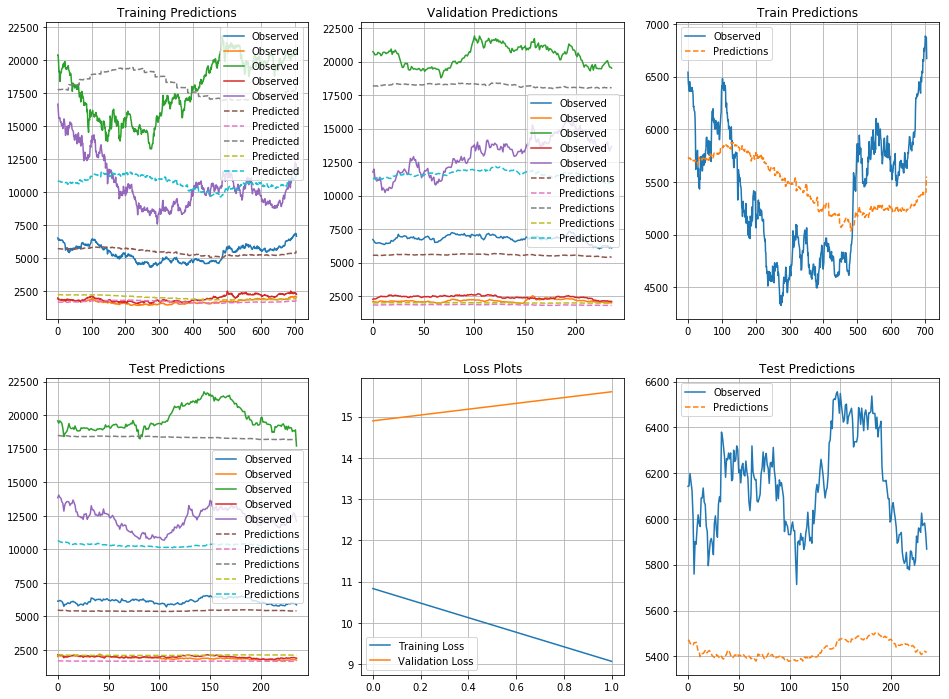

In [55]:
# Rescaling Example
fig, ax = plt.subplots(2, 3, figsize=(16, 12))

ax[0, 0].set_title("Training Predictions")
ax[0, 0].plot(train_true, label="Observed")
ax[0, 0].plot(train_pred, '--', label="Predicted")
ax[0, 0].grid()
ax[0, 0].legend()

ax[0, 1].grid()
ax[0, 1].set_title("Validation Predictions")
ax[0, 1].plot(val_true, label="Observed")
ax[0, 1].plot(val_pred, '--', label="Predictions")
ax[0, 1].legend()

ax[1, 0].grid()
ax[1, 0].set_title("Test Predictions")
ax[1, 0].plot(test_true, label="Observed")
ax[1, 0].plot(test_pred, '--', label="Predictions")
ax[1, 0].legend()

ax[1, 1].grid()
ax[1, 1].set_title("Loss Plots")
ax[1, 1].plot(learning.logs['Training Loss'], label="Training Loss")
ax[1, 1].plot(learning.logs['Validation Loss'], label="Validation Loss")
ax[1, 1].legend()

ax[0, 2].grid()
ax[0, 2].set_title("Train Predictions")
ax[0, 2].plot(train_true[:, 0], label="Observed")
ax[0, 2].plot(train_pred[:, 0], '--', label="Predictions")
ax[0, 2].legend()


ax[1, 2].grid()
ax[1, 2].set_title("Test Predictions")
ax[1, 2].plot(test_true[:, 0], label="Observed")
ax[1, 2].plot(test_pred[:, 0], '--', label="Predictions")
ax[1, 2].legend()

path = "Results/Plots/"
# plt.savefig(path + model_name + ".png")
plt.show()

### Evaluating Results

In [56]:
mse, mae, mde = evaluate(test_pred, test_true, log_ret=False)
print("Price Metrics: ", 
      mse, mae, mde)

Price Metrics:  1575021.8398395877 888.929197050568 0.4672340425531915


### Naive Example

In [57]:
test_naive = test_true[forecast_length:, :]
mse_naive, mae_naive, mde_naive = evaluate(test_naive, test_true[:-forecast_length], log_ret=False)
print("Naive: ", mse_naive, mae_naive, mde_naive)

Naive:  57732.02 147.41885 0.45130434782608697


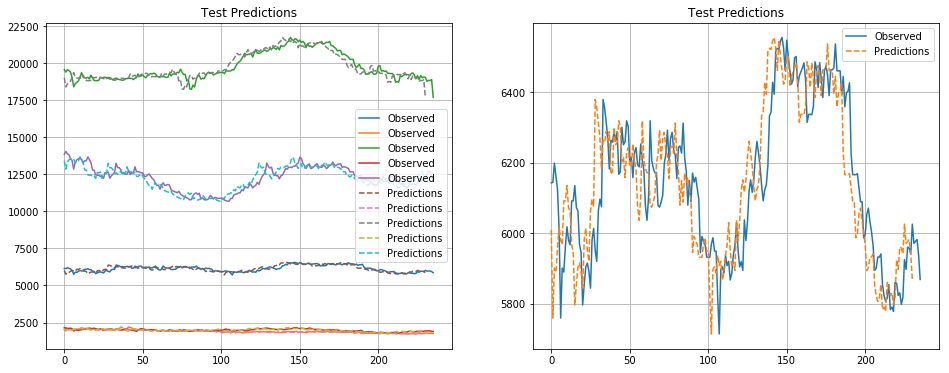

In [58]:
# Rescaling Example
fig, ax = plt.subplots(1, 2, figsize=(16, 6))


ax[0].grid()
ax[0].set_title("Test Predictions")
ax[0].plot(test_true, label="Observed")
ax[0].plot(test_naive, '--', label="Predictions")
ax[0].legend()


ax[1].grid()
ax[1].set_title("Test Predictions")
ax[1].plot(test_true[:,0][:], label="Observed")
ax[1].plot(test_naive[:,0], '--', label="Predictions")
ax[1].legend()

path = "Results/Plots/"
plt.savefig(path + "MTL_Naive_F" + str(forecast_length) + ".png")
plt.show()